In [1]:
import os, sys
from os.path import exists as file_exists
import numpy as np
import emcee
import zeus
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyu
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
from chainconsumer import ChainConsumer
import time
import h5py

In [2]:
#Load data from file, check if the data file is in the same directory of the code.

data_file = "HzTable_2020.dat"
z, Hz, errHz = np.genfromtxt(data_file, comments='#', usecols=(0,1,2), unpack=True, delimiter=',')
ref = np.genfromtxt(data_file, comments='#', usecols=(3), unpack=True, dtype=str, delimiter=',')

In [3]:
#Number of parameters to estimate
ndim = 5

#True values

#Planck
H0_pl = 67.37 
errH0_pl = 0.54
Omegam_pl = 0.308
Omegal_pl = 1 - Omegam_pl
w0 = -1
wa = 0
planck=[H0_pl, Omegam_pl, Omegal_pl, w0, wa]

#Labels and parameters for plots
labels = [r"H_0", r"\Omega_m", r"\Omega_\Lambda", r"w_0", r"w_a"]
lab = [r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$", r"$w_0$", r"$w_a$"]

z0 = np.linspace(0,2.2,500)

In [4]:
#Definition of the probability functions

#Model to fit

#LCDM
def Hz_LCDM_model(p):
    H0, Omegam = p
    return H0*np.sqrt(Omegam*(1+z)**3+(1-Omegam))

#w0waCDM
def Hz_w0wa_model(p):
    H0, Omegam, Omegal, w0, wa = p
    return H0*np.sqrt(Omegam*(1+z)**3+Omegal*((1+z)**(3+(1+w0+wa)))*np.exp(-3*wa*z/(z+1))
                      +(1-Omegam-Omegal)*(1+z)**2)

#Log-Likelihood
def lnlike(p,model):
    residual=Hz-model(p)
    return -0.5 * np.sum(residual**2/errHz**2)


#Prior LCDM

#Log-prior for mcmc sampling
def lnflatprior_LCDM_mcmc(p):
    H0, Omegam = p
            
    if (50. < H0 < 100. and 0.01 < Omegam < 0.99):
        return 0.0
    return -np.inf
    

#Log-prior for nested sampling
def lnflatprior_LCDM_nested(u):
    uH0, uOmegam = u
    
    H0 = 50 * uH0 + 50
    Omegam = 0.98 * uOmegam + 0.01
    
    return H0, Omegam


#Prior w0waCDM

#Log-prior for mcmc sampling
def lnflatprior_w0wa_mcmc(p):
    H0, Omegam, Omegal, w0, wa = p
            
    if (50. < H0 < 100. and 0.01 < Omegam < 0.99 and 0.01 < Omegal < 0.99 and -3. < w0 < 1. and -3 < wa < 2):
        return 0.0
    return -np.inf

#Log-prior for nested sampling
def lnflatprior_w0wa_nested(u):
    uH0, uOmegam, uOmegal, uw0, uwa = u
    
    H0 = 50 * uH0 + 50
    Omegam = 0.98 * uOmegam + 0.01
    Omegal = 0.98 * uOmegal + 0.01
    w0 = 4 * uw0 - 3
    wa = 5 * uwa - 3
    
    return H0, Omegam, Omegal, w0, wa

#Log-probability
def lnprob(p,model,prior):
    lp = prior(p)
    return lp + lnlike(p,model) if np.isfinite(lp) else -np.inf 

In [40]:
#Sampling function
def sampling(sampler, model, prior=None, truths, nwalkers=5*ndim, quantiles_value=[16,50,84], running_time=True):
    
    quantiles_list = list(np.array(quantiles_value)*0.01)
    quantiles_tuple = tuple(quantiles_list)
    c = ChainConsumer()
    
    #Routine for the 'emcee' sampler
    if "emcee" in sampler: 
        
        filename = "Hz_chain_emcee.h5"
        thin = 1
        burnin = 300
        
        if file_exists(filename):
            reader = emcee.backends.HDFBackend(filename)
            flat_samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
        
        else:       
            np.random.seed(123)
            p0 = truths + 0.1 * np.random.randn(nwalkers, ndim) #Initial position of walkers
            
            backend = emcee.backends.HDFBackend(filename)
            backend.reset(nwalkers, ndim)

            prob=lnprob(p,model,prior)
            
            esampler = emcee.EnsembleSampler(nwalkers, ndim, prob, backend=backend)
            start = time.time()
            esampler.run_mcmc(p0, 5000, progress=True)
            end = time.time()
        
            flat_samples = esampler.get_chain(discard=burnin, thin=thin, flat=True)
            
            if (running_time):
                sampling_time = end - start
                print("Sampling time of emcee (s):", sampling_time)
        
        #Results printing
        quantiles = np.empty([ndim, 3])
        fit_values = np.empty(ndim)
        
        print("emcee parameter estimation:")
        for i in range(ndim):
            quantiles[i][:] = np.percentile(flat_samples[:, i], quantiles_value)
            fit_values[i] =  quantiles[i][1]
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(fit_values[i], fit_values[i]-quantiles[i][0], fit_values[i]-quantiles[i][2], labels[i])
            display(Math(txt))
        
        """
        #Plots part
        if (plot):
            fig_emcee = corner.corner(flat_samples, labels=lab, truths=truths, 
                                      quantiles=quantiles_list, show_titles=True)

            plt.figure(2)
            plt.errorbar(z, Hz, yerr=errHz, fmt=".k", capsize=0)
            plt.plot(z0, truths[0]*np.sqrt(truths[1]*(1+z0)**3+(1-truths[1])), "k", label="true values")
            plt.plot(z0, fit_values[0]*np.sqrt(fit_values[1]*(1+z0)**3+(1-fit_values[1])), "r", label="emcee")
            plt.legend(fontsize=14)
            plt.xlabel("z")
            plt.ylabel("H(z)");

            fig_walkers, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
            samples = esampler.get_chain()
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(lab[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)

            axes[-1].set_xlabel("step number") 
        """
        
        c.add_chain(flat_samples, parameters=lab, name='emcee')
   
    #Routine for the 'zeus' sampler
    if "zeus" in sampler: 
        
        filename = "Hz_chain_zeus.h5"
        
        if file_exists(filename):
            with h5py.File(filename, "r") as hf:
                flat_samples = np.copy(hf['flat_samples'])
        
        else:
            np.random.seed(123)
            p0 = truths + 0.1 * np.random.randn(nwalkers, ndim) 
        
            zsampler = zeus.EnsembleSampler(nwalkers, ndim, lnprob )
            start = time.time()
            zsampler.run_mcmc(p0, 5000, progress=True)
            end = time.time()
            
            thin = 1
            burnin = 300
        
            flat_samples = zsampler.get_chain(discard=burnin, thin=thin, flat=True)
            
            hf = h5py.File(filename, 'w')
            hf.create_dataset('flat_samples', data=flat_samples)
            hf.close()

            if (running_time):
                sampling_time = end - start
                print("Sampling time of zeus (s):", sampling_time)
        
        quantiles = np.empty([ndim, 3])
        fit_values = np.empty(ndim)
        
        print("zeus parameter estimation:")
        for i in range(ndim):
            quantiles[i][:] = np.percentile(flat_samples[:, i], quantiles_value)
            fit_values[i] =  quantiles[i][1]
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(fit_values[i], fit_values[i]-quantiles[i][0], fit_values[i]-quantiles[i][2], labels[i])
            display(Math(txt))
        
        """
        if (plot):
            fig_zeus = corner.corner(flat_samples, labels=lab, 
                                     truths=truths, quantiles=quantiles_list, show_titles=True)

            plt.figure(2)
            plt.errorbar(z, Hz, yerr=errHz, fmt=".k", capsize=0)
            plt.plot(z0, truths[0]*np.sqrt(truths[1]*(1+z0)**3+(1-truths[1])), "k", label="True values")
            plt.plot(z0, fit_values[0]*np.sqrt(fit_values[1]*(1+z0)**3+(1-fit_values[1])), "r", label="zeus")
            plt.legend(fontsize=14)
            plt.xlabel("z")
            plt.ylabel("H(z)");

            fig_walkers, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
            samples = zsampler.get_chain()
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(lab[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)

            axes[-1].set_xlabel("step number") 
            """
        
        c.add_chain(flat_samples, parameters=lab, name='zeus')
             
    #Routine for the 'dynesty' sampler
    if "dynesty" in sampler:
        
        filename = "Hz_chain_dynesty.h5"
        
        if file_exists(filename):
            with h5py.File(filename, "r") as hf:
                flat_samples = np.copy(hf['flat_samples'])
                importance_weights = np.copy(hf['weights'])
                evidence = np.copy(hf['evidence'])
        else:
            rstate = np.random.default_rng(56101)
        
            dsampler = dynesty.DynamicNestedSampler(lnlike, lnflatprior_nested, ndim=ndim, 
                                                bound='multi', sample='unif', rstate=rstate)
            start = time.time()
            dsampler.run_nested()
            end = time.time()
            dres = dsampler.results
            flat_samples = dres.samples
            importance_weights = dres.importance_weights()
            evidence = dres.logz
            
            hf = h5py.File(filename, 'w')
            hf.create_dataset('flat_samples', data=dres.samples)
            hf.create_dataset('weights', data=weights)
            hf.create_dataset('evidence', data=evidence)
            hf.close()
            
            if (running_time):
                sampling_time = end - start
                print("Sampling time of dynesty (s):", sampling_time)
        
        quantiles = np.empty([ndim, 3])
        fit_values = np.empty(ndim)

        print("dynesty parameter estimation:")
        for i in range(ndim):
            q=np.array(quantiles_list)
            sampx = np.atleast_1d(flat_samples[:,i])
            weights = importance_weights
            weights = np.atleast_1d(weights)
            idx = np.argsort(sampx)  # sort samples
            sw = weights[idx]  # sort weights
            cdf = np.cumsum(sw)[:-1]  # compute CDF
            cdf /= cdf[-1]  # normalize CDF
            cdf = np.append(0, cdf)  # ensure proper span
            quantiles[i][:] = np.interp(q, cdf, sampx[idx]).tolist()
            fit_values[i] = quantiles[i][1]
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            txt = txt.format(fit_values[i], fit_values[i]-quantiles[i][0], fit_values[i]-quantiles[i][2], labels[i])
            display(Math(txt))
        
        print("The evidence is:",evidence[-1])
        
        """"
        if (plot):
            fig_dynesty, axes = dyplot.cornerplot(dres, truths=truths, quantiles=quantiles_tuple, show_titles=True, 
                                                  title_kwargs={'y': 1.04}, labels=lab,
                                                  fig=plt.subplots(ndim, ndim, figsize=(15, 15)), 
                                                  title_quantiles=quantiles_tuple)

            plt.figure(2)
            plt.errorbar(z, Hz, yerr=errHz, fmt=".k", capsize=0)
            plt.plot(z0, truths[0]*np.sqrt(truths[1]*(1+z0)**3+(1-truths[1])), "k", label="True values")
            plt.plot(z0, fit_values[0]*np.sqrt(fit_values[1]*(1+z0)**3+(1-fit_values[1])), "g", label="dynesty")
            plt.legend(fontsize=14)
            plt.xlabel("z")
            plt.ylabel("H(z)");

            fig, axes = dyplot.traceplot(dres, truths=truths, quantiles=quantiles_tuple, labels=lab,
                         fig=plt.subplots(ndim, 2, figsize=(16, 12)),
                         truth_color='black', show_titles=True, title_quantiles=quantiles_tuple,
                         trace_cmap='viridis')
            fig.tight_layout()
            
         """
            
        c.add_chain(flat_samples, parameters=lab, weights=importance_weights, name='dynesty')
    
    c.configure(statistics='mean',legend_artists=True, sigma2d=True)
    fig = c.plotter.plot(truth=truths)
    fig1 = c.plotter.plot_walks(truth=truths, convolve=150)
    fig2 = c.plotter.plot_distributions(truth=truths)
    fig.set_size_inches(3 + fig.get_size_inches())
    fig1.set_size_inches(3 + fig1.get_size_inches())
    fig2.set_size_inches(3 + fig2.get_size_inches())
        
      

100%|██████████| 5000/5000 [00:45<00:00, 110.04it/s]


Sampling time of emcee (s): 45.511784076690674
emcee parameter estimation:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

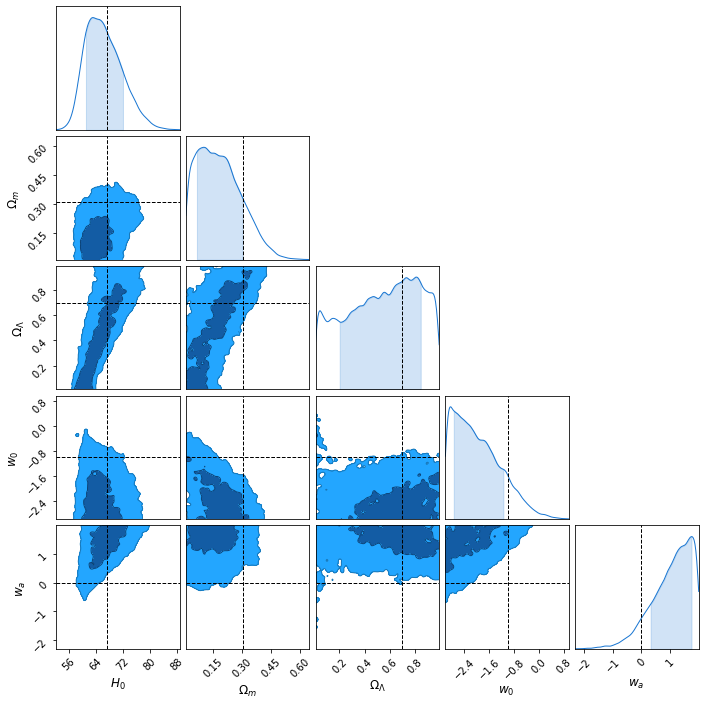

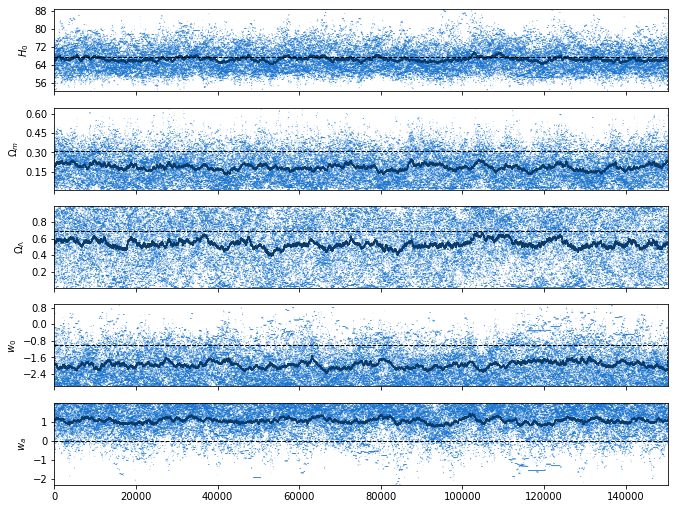

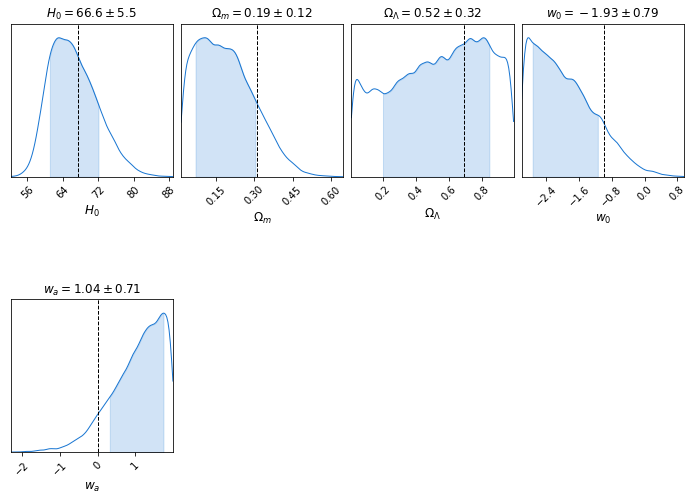

In [43]:
sampling(["emcee"], Hz_w0wa_model,  planck, 32)